# Masters_Research_Project_using_Sentinel_2

This research project is intending to find out whether medium resolution Sentinel 2a imagery can be used to calculate vegetation fuel load in South East Queensland.


The amount of fuel load present in forested vegetation is directly proportional to the severity of a bushfire in the forest.  The severity is also proportional to characteristics
such as vegetation type, moisture content in the vegetation, arrangement of the vegetation and terrain present.  
Therefore, understanding how, why and calculation of vegetation fuel load is important in understanding drivers of a bushfire event and its severity.

The *European Space Agency* (*ESA*) has operated medium resolution satellites - Sentinel-2 series (Sentinel-2A and Sentinel-2B) since 2015. 

### Import libraries and modules

In [98]:
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import datacube.virtual as virtual
import geopandas as gpd

import sys
sys.path.insert(1, '../Tools/')

from dea_tools.plotting import display_map
from dea_tools.spatial import xr_rasterize, xr_vectorize
from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import display_map, rgb
from odc.io.cgroups import get_cpu_quota
import subprocess
from rasterio.mask import raster_geometry_mask
from shapely.geometry import box

In [99]:
""" additions """

from dea_tools.datahandling import load_ard   # added this
from dea_tools.bandindices import calculate_indices # added this

In [100]:
import rasterio
from rasterio.features import geometry_mask

### Connect to the Datacube

In [101]:
dc = datacube.Datacube(app="Sentinel_2_Vegetation_Fuel_Load")

### Set Study Areas with central coordinates and buffers in latitude (20m) and longitude (50m) shown in decimal degrees.

In [102]:
# List of central latitude and longitude coordinates for the field sites
field_sites = [
    (-27.49415846, 152.7408134),  # Field site 1
    (-27.4996146, 152.7388185),  # Field site 2
    (-27.50965686, 152.7975522),  # Field site 3
    (-27.52625347, 152.864255),  # Field site 4
    (-27.52778734, 152.8633343),  # Field site 5
    (-27.53948472, 153.1528979),  # Field site 6
    (-27.53771376, 153.1447333),  # Field site 7
    (-27.52950791, 153.1448171),  # Field site 8
    (-27.55665257, 152.8541602),  # Field site 9
    (-27.55483345, 152.8511169), # Field site 10
    (-27.55482989, 152.8551187),  # Field site 11
    (-27.57918881, 153.1671666),  # Field site 12
]

# Set the buffer to load around the central coordinates, 50m by 20m.
buffer_lat = 0.00200
buffer_lon = 0.00500

In [103]:
# step 1 check the buffer distance using geopy library
import geopy.distance

coords_1 = (-27.49415846, 152.7408134)
coords_2 = (-27.49415846, 152.7408134+buffer_lon)

print(geopy.distance.geodesic(coords_1, coords_2).km)

coords_1 = (-27.49415846, 152.7408134)
coords_2 = (-27.49415846+buffer_lat, 152.7408134)

print(geopy.distance.geodesic(coords_1, coords_2).km)

0.49408676965721277
0.22162265468690107


In [104]:
""" note the above output is in km, so we are 1 decimal place off our desired ROI of 50m x 20m (i.e. currently 500m x 220m) """

# Set the buffer to load around the central coordinates, 50m by 20m.
buffer_lat = 0.000180
buffer_lon = 0.000505

coords_1 = (-27.49415846, 152.7408134-buffer_lon/2)
coords_2 = (-27.49415846, 152.7408134+buffer_lon/2)

print(geopy.distance.geodesic(coords_1, coords_2).km)

coords_1 = (-27.49415846-buffer_lat/2, 152.7408134)
coords_2 = (-27.49415846+buffer_lat/2, 152.7408134)

print(geopy.distance.geodesic(coords_1, coords_2).km)   

# now we have our desired bounds

0.04990276373631301
0.01994604178853261


In [105]:
""" step 2. Find our best image 
> single ROI example """ 

# Compute a single median from all data
#ds_median = ds.median('time')

# View the resulting median
#rgb(ds_median)


""" specify our constants """

# Set the data source - s2a corresponds to Sentinel-2A and s2b corresponds to Sentinel -2B
set_product = ("ga_s2am_ard_3", "ga_s2bm_ard_3")

# Set the date range to load data over
time_range = ("2022-09-01", "2022-09-30")

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
set_crs = "epsg:32756"  # 'epsg:3577'

set_resolution = (-10, 10)

In [106]:
type(time_range)

tuple

In [107]:
# Combine central lat,lon with buffer to get area of interest
lat = field_sites[0][0]   # extract 1st set of coords from our field_sites list
lon = field_sites[0][1]

lat_range = (lat - buffer_lat/2, lat + buffer_lat/2)
lon_range = (lon - buffer_lon/2, lon + buffer_lon/2)

print(lat_range, lon_range)

(-27.49424846, -27.49406846) (152.74056090000002, 152.7410659)


In [108]:
# Call the display_map function to visualize the study area
display_map(x=lon_range, y=lat_range)   # Note we appear to be in a field for our first study site

In [109]:
# Create a reusable query - all bands and variables
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'resolution': set_resolution,
    'output_crs': set_crs,
    'group_by': 'solar_day'
} 

# Load available data
ds = load_ard(
    dc=dc,
    products=set_product,
    min_gooddata=0.90,
    **query,
)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 3 out of 6 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 3 time steps


In [110]:
ds

<xarray.Dataset>
Dimensions:                     (time: 3, y: 3, x: 6)
Coordinates:
  * time                        (time) datetime64[ns] 2022-09-01T00:04:24.314...
  * y                           (y) float64 6.959e+06 6.959e+06 6.959e+06
  * x                           (x) float64 4.744e+05 4.744e+05 ... 4.744e+05
    spatial_ref                 int32 32756
Data variables: (12/27)
    nbart_coastal_aerosol       (time, y, x) float32 733.0 733.0 ... 451.0 347.0
    nbart_blue                  (time, y, x) float32 771.0 788.0 ... 524.0 496.0
    nbart_green                 (time, y, x) float32 881.0 902.0 ... 817.0 824.0
    nbart_red                   (time, y, x) float32 895.0 936.0 ... 770.0 710.0
    nbart_red_edge_1            (time, y, x) float32 1.123e+03 ... 1.08e+03
    nbart_red_edge_2            (time, y, x) float32 1.6e+03 ... 2.092e+03
    ...                          ...
    oa_solar_zenith             (time, y, x) float32 43.9 43.9 ... 34.96 34.96
    oa_time_delta               (time, y, x) float32 -3.652 -3.653 ... -3.363
    oa_s2cloudless_mask         (time, y, x) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
    oa_s2cloudless_prob         (time, y, x) float32 0.2646 0.2646 ... 0.03037
    oa_fmask                    (time, y, x) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    oa_nbart_contiguity         (time, y, x) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes:
    crs:           epsg:32756
    grid_mapping:  spatial_ref

In [111]:
list(np.arange(0,len(ds.time),1))

[0, 1, 2]

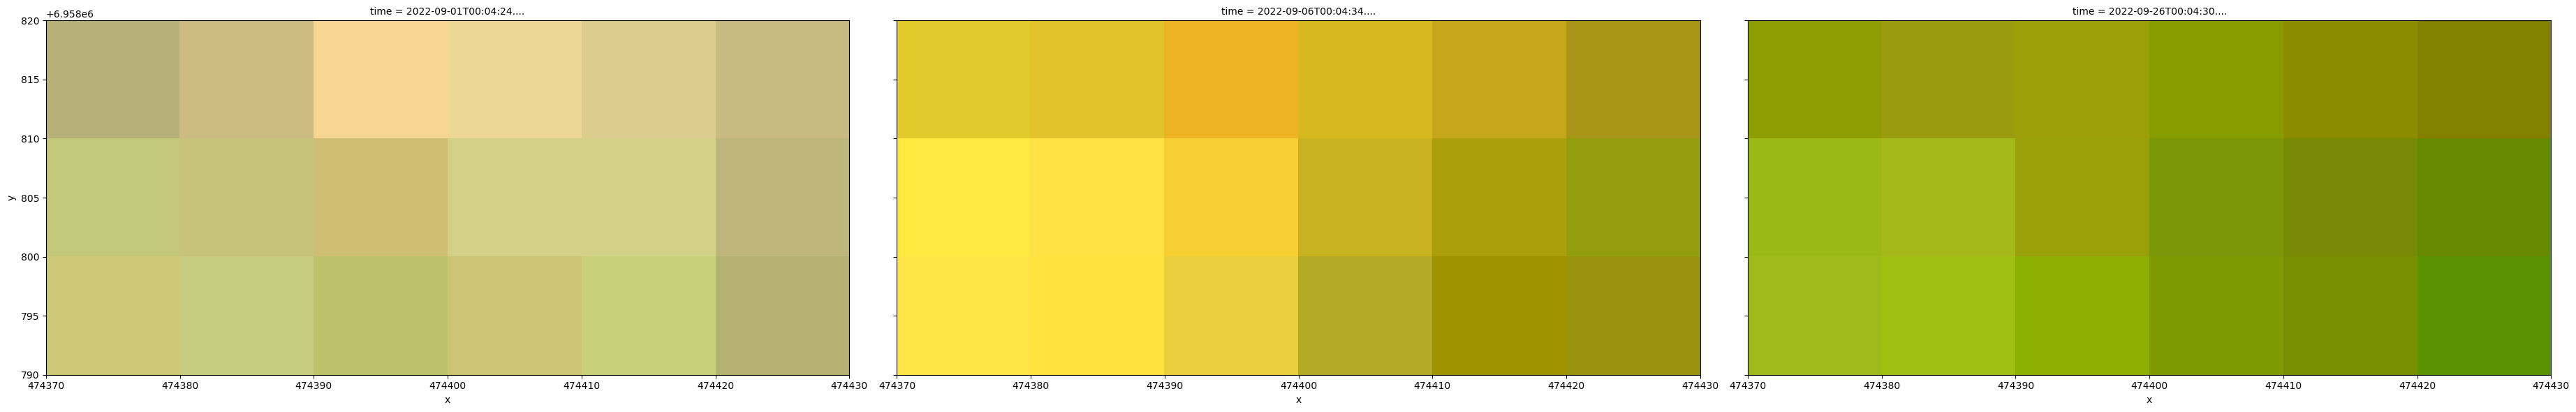

In [112]:
""" RGB plot of timestamps """

rgb(ds, index=list(np.arange(0,len(ds.time),1)),col_wrap=3)   # note this won't be super informative as such a small scale. Suggest to increase lat, long by x10 or x30

In [113]:
""" Step 3. add extra indices """

# Calculate the chosen vegetation proxy index and add it to the loaded data set
veg_proxy_list = ['EVI','NDVI','NBR'] #'NDVI'#

for i_var in veg_proxy_list:   # loop over the veg_proxy_list to add the VIs to the ds
    print(i_var)
    ds = calculate_indices(ds, index=i_var, collection='ga_s2_3')
    # Save the NDVI to the dask cluster
    ds[i_var] = ds[i_var]

EVI
NDVI
NBR


In [114]:
ds

<xarray.Dataset>
Dimensions:                     (time: 3, y: 3, x: 6)
Coordinates:
  * time                        (time) datetime64[ns] 2022-09-01T00:04:24.314...
  * y                           (y) float64 6.959e+06 6.959e+06 6.959e+06
  * x                           (x) float64 4.744e+05 4.744e+05 ... 4.744e+05
    spatial_ref                 int32 32756
Data variables: (12/30)
    nbart_coastal_aerosol       (time, y, x) float32 733.0 733.0 ... 451.0 347.0
    nbart_blue                  (time, y, x) float32 771.0 788.0 ... 524.0 496.0
    nbart_green                 (time, y, x) float32 881.0 902.0 ... 817.0 824.0
    nbart_red                   (time, y, x) float32 895.0 936.0 ... 770.0 710.0
    nbart_red_edge_1            (time, y, x) float32 1.123e+03 ... 1.08e+03
    nbart_red_edge_2            (time, y, x) float32 1.6e+03 ... 2.092e+03
    ...                          ...
    oa_s2cloudless_prob         (time, y, x) float32 0.2646 0.2646 ... 0.03037
    oa_fmask                    (time, y, x) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    oa_nbart_contiguity         (time, y, x) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    EVI                         (time, y, x) float32 0.2013 0.2128 ... 0.388
    NDVI                        (time, y, x) float32 0.339 0.3459 ... 0.5928
    NBR                         (time, y, x) float32 0.2718 0.2857 ... 0.3351
Attributes:
    crs:           epsg:32756
    grid_mapping:  spatial_ref

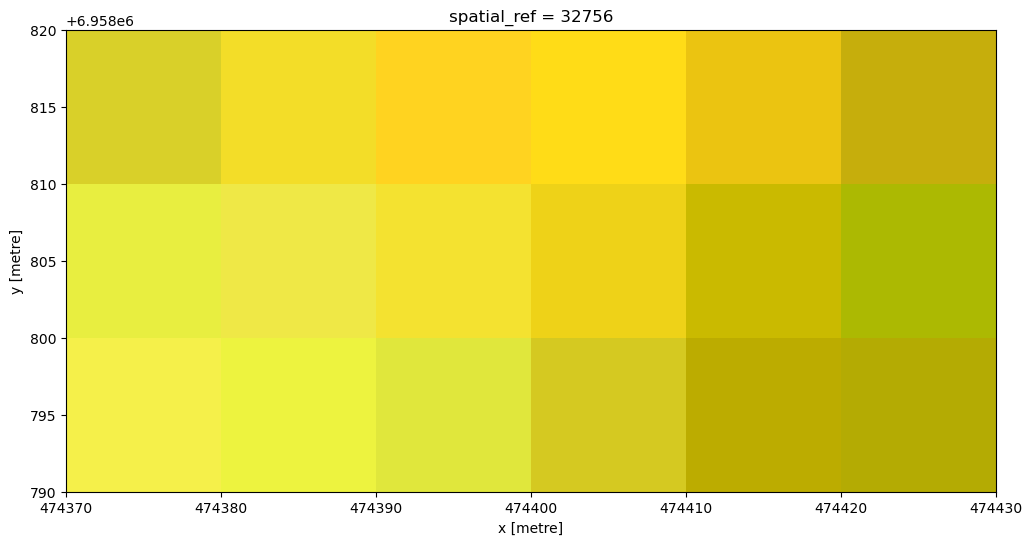

In [115]:
""" Step 4. compute a median for our ROI """

# Compute a single median from all data
ds_median = ds.median('time')

# View the resulting median
rgb(ds_median)

In [116]:
ds_median

<xarray.Dataset>
Dimensions:                     (y: 3, x: 6)
Coordinates:
  * y                           (y) float64 6.959e+06 6.959e+06 6.959e+06
  * x                           (x) float64 4.744e+05 4.744e+05 ... 4.744e+05
    spatial_ref                 int32 32756
Data variables: (12/30)
    nbart_coastal_aerosol       (y, x) float32 533.0 533.0 533.0 ... 533.0 383.0
    nbart_blue                  (y, x) float32 623.0 622.0 609.0 ... 535.0 564.0
    nbart_green                 (y, x) float32 881.0 902.0 886.0 ... 825.0 824.0
    nbart_red                   (y, x) float32 895.0 936.0 ... 850.0 838.0
    nbart_red_edge_1            (y, x) float32 1.355e+03 1.343e+03 ... 1.08e+03
    nbart_red_edge_2            (y, x) float32 2.411e+03 2.373e+03 ... 2.016e+03
    ...                          ...
    oa_s2cloudless_prob         (y, x) float32 0.09407 0.09407 ... 0.0507
    oa_fmask                    (y, x) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    oa_nbart_contiguity         (y, x) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    EVI                         (y, x) float32 0.3313 0.3211 ... 0.3433 0.326
    NDVI                        (y, x) float32 0.4869 0.4781 ... 0.5278 0.5101
    NBR                         (y, x) float32 0.2718 0.2814 ... 0.3002 0.3263

In [117]:
""" define our band (data variable) we want to export and compute a mean and SD """

measurement_list = ['EVI','nbart_red', 'nbart_green', 'nbart_blue', 
                     'nbart_red_edge_1', 'nbart_red_edge_2', 'nbart_red_edge_3', 
                     'nbart_nir_1','nbart_nir_2',
                     'nbart_swir_2', 'nbart_swir_3']

mu_list_ind = []
sd_list_ind = []

for i_var in measurement_list:
    mu_list_ind.append(ds_median[i_var].mean(['x', 'y']).item())
    #sd_list_ind.append(ds_median[i_var].std(['x', 'y']).item())   


#all_df.to_csv('S3_all_ind_df_ang_all_bands_1kmROI_v' + timestep+ '.csv')

In [118]:
mu_list_ind

[0.33008506894111633,
 907.388916015625,
 883.0555419921875,
 610.5,
 1280.8333740234375,
 2318.5,
 2609.72216796875,
 2786.166748046875,
 2921.9443359375,
 2773.5,
 1586.0]

In [119]:
""" add data to a dataframe """
all_df = pd.DataFrame()
all_df = pd.DataFrame(index=measurement_list,data=mu_list_ind
                      ,columns=['Site1'])   # this is our mean
all_df_SD = pd.DataFrame(index=measurement_list,data=sd_list_ind,columns=['Site1'])   # this is our SD


In [120]:
all_df

,Site1
EVI,0.330085
nbart_red,907.388916
nbart_green,883.055542
nbart_blue,610.500000
nbart_red_edge_1,1280.833374
nbart_red_edge_2,2318.500000
nbart_red_edge_3,2609.722168
nbart_nir_1,2786.166748
nbart_nir_2,2921.944336
nbart_swir_2,2773.500000


In [121]:
""" test a dataframe concatenation in prep for adding multiple sites with a loop """
all_df2 = pd.DataFrame(index=measurement_list,data=mu_list_ind,columns=['Site2'])
pd.concat([all_df,all_df2*2],axis=1)

,Site1,Site2
EVI,0.330085,0.660170
nbart_red,907.388916,1814.777832
nbart_green,883.055542,1766.111084
nbart_blue,610.500000,1221.000000
nbart_red_edge_1,1280.833374,2561.666748
nbart_red_edge_2,2318.500000,4637.000000
nbart_red_edge_3,2609.722168,5219.444336
nbart_nir_1,2786.166748,5572.333496
nbart_nir_2,2921.944336,5843.888672
nbart_swir_2,2773.500000,5547.000000


In [122]:
field_sites

[(-27.49415846, 152.7408134),
 (-27.4996146, 152.7388185),
 (-27.50965686, 152.7975522),
 (-27.52625347, 152.864255),
 (-27.52778734, 152.8633343),
 (-27.53948472, 153.1528979),
 (-27.53771376, 153.1447333),
 (-27.52950791, 153.1448171),
 (-27.55665257, 152.8541602),
 (-27.55483345, 152.8511169),
 (-27.55482989, 152.8551187),
 (-27.57918881, 153.1671666)]

In [123]:
""" Loop for all sites """

""" define our band (data variable) we want to export and compute a mean and SD """
measurement_list = ['EVI','nbart_red', 'nbart_green', 'nbart_blue', 
                     'nbart_red_edge_1', 'nbart_red_edge_2', 'nbart_red_edge_3', 
                     'nbart_nir_1','nbart_nir_2',
                     'nbart_swir_2', 'nbart_swir_3']


all_df = pd.DataFrame()  #  dataframe to add our band means for each site


for site_idx, (central_lat, central_lon) in enumerate(field_sites):
    # if site_idx < 2:
        site_name = 'site_'+str(site_idx)
        print(site_name)

        lat_range = (central_lat - buffer_lat/2, central_lat + buffer_lat/2)
        lon_range = (central_lon - buffer_lon/2, central_lon + buffer_lon/2)
        print(lat_range,lon_range)

        # Create a reusable query - all bands and variables
        query = {
            'y': lat_range,
            'x': lon_range,
            'time': time_range,
            'resolution': set_resolution,
            'output_crs': set_crs,
            'group_by': 'solar_day'
        } 

        # Load available data
        ds = load_ard(
            dc=dc,
            products=set_product,
            min_gooddata=0.90,
            **query,
        )

        """ add extra indices """
        # Calculate the chosen vegetation proxy index and add it to the loaded data set
        veg_proxy_list = ['EVI','NDVI','NBR'] #'NDVI'#
        for i_var in veg_proxy_list:   # loop over the veg_proxy_list to add the VIs to the ds
            ds = calculate_indices(ds, index=i_var, collection='ga_s2_3')
            # Save the NDVI to the dask cluster
            ds[i_var] = ds[i_var]

        # Compute a single median from all data
        ds_median = ds.median('time')

        # create lists to add our means
        mu_list_ind = []
        sd_list_ind = []

        for i_var in measurement_list:   # add our means to our lists
            mu_list_ind.append(ds_median[i_var].mean(['x', 'y']).item())
            sd_list_ind.append(ds_median[i_var].std(['x', 'y']).item())  

        all_df_ind = pd.DataFrame(index=measurement_list,data=mu_list_ind,columns=[site_name])   # this is a df for a single site
        all_df = pd.concat([all_df,all_df_ind],axis=1)

all_df    

site_0
(-27.49424846, -27.49406846) (152.74056090000002, 152.7410659)
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 3 out of 6 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 3 time steps
site_1
(-27.4997046, -27.4995246) (152.73856600000002, 152.739071)
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 4 out of 6 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 4 time steps
site_2
(-27.50974686, -27.50956686) (152.79729970000002, 152.7978047)
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 3 out of 6 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 3 time steps
site_3
(-27.52634347, -27.52616347) (152.86400

,site_0,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,site_11
EVI,0.330085,0.366500,0.379508,0.367265,0.424685,0.338362,0.381454,0.324476,0.377549,0.449087,0.350726,0.294826
nbart_red,907.388916,612.722229,379.466675,497.933319,587.444458,290.500000,334.416656,515.611084,607.166687,406.138885,571.611084,847.944458
nbart_green,883.055542,680.666687,483.733337,566.133362,670.027771,375.944458,351.500000,508.500000,669.708313,563.805542,647.722229,745.055542
nbart_blue,610.500000,501.333344,424.466675,513.066650,587.805542,255.166672,270.194458,365.611115,507.041656,424.777771,576.444458,553.833313
nbart_red_edge_1,1280.833374,1040.833374,689.666687,731.466675,971.027771,630.555542,639.388916,809.388916,1047.375000,792.694458,819.777771,1128.666626
nbart_red_edge_2,2318.500000,2079.166748,1753.333374,1546.400024,2159.611084,1487.694458,1615.777832,1621.388916,2043.083374,2024.750000,1575.111084,1811.833374
nbart_red_edge_3,2609.722168,2293.972168,2084.066650,2004.000000,2427.583252,1766.611084,1990.055542,1931.111084,2387.041748,2451.083252,1968.111084,2078.500000
nbart_nir_1,2786.166748,2389.361084,2224.133301,2054.866699,2571.972168,1870.361084,2189.722168,2161.444336,2478.125000,2538.888916,2049.333252,2443.277832
nbart_nir_2,2921.944336,2577.277832,2367.533447,2295.533447,2711.000000,2014.972168,2279.000000,2237.166748,2682.875000,2732.416748,2249.333252,2461.500000
nbart_swir_2,2773.500000,1688.861084,1222.333374,1103.733276,1487.472168,1093.388916,1183.611084,1650.000000,1761.000000,1188.777832,1317.722168,2463.777832


In [124]:
""" export df """
all_df.to_csv('S2_all_sites.csv')

In [125]:
pwd

'/home/jovyan/Beginners_guide'

# RF model

In [126]:
pip install openpyxl # required to open xlsx files

Note: you may need to restart the kernel to use updated packages.


In [127]:
""" load reference data """
ref_df = pd.read_excel('Field Survey Data.xlsx',sheet_name='Sheet2')

In [128]:
""" load reference data """
ref_df2 = pd.read_excel('Field Survey Data.xlsx',sheet_name='Sheet1')


In [129]:
ref_df

,Site #,Dataset (DS) Index for Python,Latitude (GDA2020),Longitude (GDA2020),Date,Remnant Status,Desktop RE,Groundtruthed RE,VHC,Vegetation Condition Class,...,S2 Cover (%),S2 Species,Basal Area,Ground Layer Notes,Dominant Groundcover,Surface Fine Fuels Average (%),Near Surface Fine Fuels Average (%),Litter Depth Average (mm),General Site Notes,Incidental Flora
0,1,0,27.494158,152.740813,2022-09-07,nonremnant (cleared),Nonremnant,Nonremnant,39.b,7,...,NaN,NaN,0,"Dominated by managed non native grass, cleared...",Poaceae Unknown,100.0,100.0,1.0,"Dominated by managed non native grass, cleared...",NaN
1,2,1,27.499615,152.738818,2022-09-07,regrowth,12.11.6,Regrowth 12.11.6,10.2,3,...,0.0,NaN,11,Dominated by exotic species such as Melinis re...,"Ageratum houstonianum (exotic),Bidens pilosa (...",100.0,99.0,36.0,Regrowth on the edge of a cleared patch and un...,NaN
2,3,2,27.509657,152.797552,2022-09-07,remnant,12.11.3a,12.11.3a,9.2,1,...,0.0,NaN,14,Dominated by lantana montevensis with billy go...,NaN,99.0,34.0,24.0,In a gully / low lying area next to an ephemer...,NaN
3,4,3,27.526253,152.864255,2022-08-31,remnant,12.11.5,12.11.5,10.1,1,...,0.0,NaN,10,NaN,"Aristida sp.,Lomandra multiflora,Themeda triandra",9.0,86.8,9.0,NaN,"Achyranthes aspera,Cymbopogon refractus,Entola..."
4,5,4,27.527787,152.863334,2022-08-31,remnant,12.11.3,12.11.5,10.1,1,...,0.0,NaN,23,NaN,"Entolasia stricta,Lomandra confertifolia,Theme...",8.0,81.0,13.0,NaN,"Dianella sp.,Hibbertia sp.,Senecio sp."
5,6,5,27.539485,153.152898,2022-08-30,remnant,12.910.22,12.910.22,22.5,1,...,7.0,"Pultenaea robusta, Melaleuca sp., Leptospermum...",4,Dominated by Shoenus brevifolius,Shoenus brevifolius,2.6,56.0,9.2,NaN,"Burchardia umbellata,Cassytha sp.,Drosera sp.,..."
6,7,6,27.537714,153.144733,2022-08-30,remnant,12.910.4,12.910.4,9.2,2,...,0.0,NaN,14,NaN,"Cymbopogon refractus,Gahnia sp.,Imperata cylin...",21.0,56.0,9.0,NaN,Platylobium formosum
7,8,7,27.529508,153.144817,2022-08-30,nonremnant (cleared),Nonremnant,Nonremnant,39.a,3,...,0.0,NaN,4,NaN,"Eragrostis sp.,Festuca sp.,Gahnia sp.,Lomandra...",21.4,19.0,25.0,Transect is upslope,Entolasia stricta
8,9,8,27.556653,152.854160,2022-08-31,nonremnant (cleared),Non remnant,Non remnant,39.a,6,...,0.0,NaN,0,NaN,"Ageratum conyzoides (exotic),Bidens pilosa (ex...",3.4,58.0,5.0,NaN,"Ageratum conyzoides (exotic),Bidens pilosa (ex..."
9,10,9,27.554833,152.851117,2022-08-31,regrowth,12.3.3,Rehabilitated 12.3.7/12.3.3,16.1,4,...,0.0,NaN,9,NaN,"Cardiospermum grandiflorum (exotic),Commelina ...",13.0,77.0,7.0,NaN,"Asparagus africanus (exotic),Lantana camara (e..."


In [130]:
filtered_df = ref_df2[(ref_df2['Remnant Status'] == 'remnant') & (ref_df2['EDL'] != 'Water')]   # filter the df for an auto loop

In [131]:
filtered_df

,Sequence,Latitude (GDA2020),Longitude (GDA2020),Site name,Date,Time,Collector(s),Remnant Status,Desktop RE,Groundtruthed RE,...,S2 Cover (%),S2 Species,Basal Area,Ground Layer Notes,Dominant Groundcover,Surface Fine Fuels Average (%),Near Surface Fine Fuels Average (%),Litter Depth Average (mm),General Site Notes,Incidental Flora
3,NaN,27.498831,152.814717,56s.4816996958299,44811,0.559028,"Gina Minatel,Katelyn Gibson",remnant,12.12.15b,12.12.15b,...,0.0,NaN,23.0,Dominated by mostly native species with a thic...,"Chrysocephalum apiculatum,Lantana montevidensi...",99,35.0,38.0,"Site located on a slope, open understory with ...",NaN
4,3.0,27.509657,152.797552,56s.479999.6957099,44811,0.438194,"Gina Minatel,Katelyn Gibson",remnant,12.11.3a,12.11.3a,...,0.0,NaN,14.0,Dominated by lantana montevensis with billy go...,NaN,99,34.0,24.0,In a gully / low lying area next to an ephemer...,NaN
5,4.0,27.510465,152.776266,56s.477899.6956999,44811,0.361111,"Gina Minatel,Katelyn Gibson",remnant,12.11.6,12.11.6,...,0.0,NaN,16.0,Dominated by lantana montdevensis forming a ma...,NaN,80.6,63.0,12.4,NaN,NaN
6,5.0,27.526253,152.864255,56s.486599.6955299,44804,0.474306,"Gillian Turner,Jacinta Harrison",remnant,12.11.5,12.11.5,...,0.0,NaN,10.0,NaN,"Aristida sp.,Lomandra multiflora,Themeda triandra",9,86.8,9.0,NaN,"Achyranthes aspera,Cymbopogon refractus,Entola..."
7,6.0,27.527787,152.863334,56s.486499.6955099,44804,0.474306,"Gillian Turner,Jacinta Harrison",remnant,12.11.3,12.11.5,...,0.0,NaN,23.0,NaN,"Entolasia stricta,Lomandra confertifolia,Theme...",8,81.0,13.0,NaN,"Dianella sp.,Hibbertia sp.,Senecio sp."
8,7.0,27.539485,153.152898,56s.515099.6953799,44803,0.159028,"David Gatfield,Jacinta Harrison",remnant,12.910.22,12.910.22,...,7.0,"Pultenaea robusta, Melaleuca sp., Leptospermum...",4.0,Dominated by Shoenus brevifolius,Shoenus brevifolius,2.6,56.0,9.2,NaN,"Burchardia umbellata,Cassytha sp.,Drosera sp.,..."
9,8.0,27.537714,153.144733,56s.514299.6953999,44803,0.284028,"David Gatfield,Jacinta Harrison",remnant,12.910.4,12.910.4,...,0.0,NaN,14.0,NaN,"Cymbopogon refractus,Gahnia sp.,Imperata cylin...",21,56.0,9.0,NaN,Platylobium formosum
10,NaN,27.535878,153.146843,56s.51499.6954199,44803,0.417361,"David Gatfield,Jacinta Harrison",remnant,12.11.24,12.11.24,...,0.0,NaN,9.0,NaN,"Cymbopogon refractus,Lomandra sp.",32,37.0,52.5,NaN,Passiflora sp.
21,NaN,27.498010,153.112394,56s.511099.6958399,44805,0.270833,"Gina Minatel,Katelyn Gibson",remnant,12.11.14,12.11.14,...,0.0,NaN,7.0,Dense weedy ground cover layer,"Ageratum houstonianum (exotic),Lantana camara ...",100,90.0,13.0,Dense thicket understory dominated by lantana ...,NaN
23,NaN,27.543072,153.143786,56s.514199.6953399,44803,0.740278,"David Gatfield,Jacinta Harrison",remnant,12.3.6,12.910.12,...,0.0,NaN,14.0,NaN,"Gahnia aspera,Xanthorrhoea sp.",11,7.0,40.0,NaN,"Acacia fimbriata,Clematis pickeringii,Lantana ..."


In [132]:
# Call the display_map function to visualize the study area
display_map(x=lon_range, y=lat_range)   # Note we appear to be in a field for our first study site

In [133]:
""" specify reponse variable """

resp_var = pd.to_numeric(ref_df["Litter Depth Average (mm)"].values)

In [134]:
resp_var

array([ 1. , 36. , 24. ,  9. , 13. ,  9.2,  9. , 25. ,  5. ,  7. ,  9.4,
        1.6])

In [135]:
""" swap rows and cols in all_df """

all_df_pred = all_df.T

all_df_pred

,EVI,nbart_red,nbart_green,nbart_blue,nbart_red_edge_1,nbart_red_edge_2,nbart_red_edge_3,nbart_nir_1,nbart_nir_2,nbart_swir_2,nbart_swir_3
site_0,0.330085,907.388916,883.055542,610.500000,1280.833374,2318.500000,2609.722168,2786.166748,2921.944336,2773.500000,1586.000000
site_1,0.366500,612.722229,680.666687,501.333344,1040.833374,2079.166748,2293.972168,2389.361084,2577.277832,1688.861084,923.555542
site_2,0.379508,379.466675,483.733337,424.466675,689.666687,1753.333374,2084.066650,2224.133301,2367.533447,1222.333374,543.866638
site_3,0.367265,497.933319,566.133362,513.066650,731.466675,1546.400024,2004.000000,2054.866699,2295.533447,1103.733276,480.733337
site_4,0.424685,587.444458,670.027771,587.805542,971.027771,2159.611084,2427.583252,2571.972168,2711.000000,1487.472168,704.138916
site_5,0.338362,290.500000,375.944458,255.166672,630.555542,1487.694458,1766.611084,1870.361084,2014.972168,1093.388916,517.972229
site_6,0.381454,334.416656,351.500000,270.194458,639.388916,1615.777832,1990.055542,2189.722168,2279.000000,1183.611084,560.166687
site_7,0.324476,515.611084,508.500000,365.611115,809.388916,1621.388916,1931.111084,2161.444336,2237.166748,1650.000000,825.611084
site_8,0.377549,607.166687,669.708313,507.041656,1047.375000,2043.083374,2387.041748,2478.125000,2682.875000,1761.000000,934.875000
site_9,0.449087,406.138885,563.805542,424.777771,792.694458,2024.750000,2451.083252,2538.888916,2732.416748,1188.777832,585.250000


Text(0, 0.5, 'ref values')

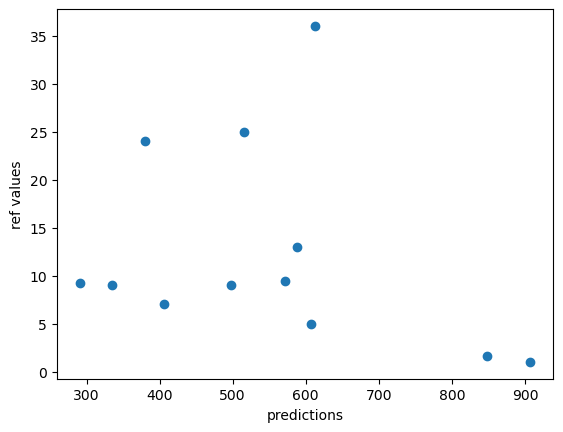

In [136]:
#plt.scatter(all_df_pred.EVI,resp_var)
plt.scatter(all_df_pred.nbart_red,resp_var)
plt.xlabel('predictions')
plt.ylabel('ref values')

In [137]:
all_df_pred

,EVI,nbart_red,nbart_green,nbart_blue,nbart_red_edge_1,nbart_red_edge_2,nbart_red_edge_3,nbart_nir_1,nbart_nir_2,nbart_swir_2,nbart_swir_3
site_0,0.330085,907.388916,883.055542,610.500000,1280.833374,2318.500000,2609.722168,2786.166748,2921.944336,2773.500000,1586.000000
site_1,0.366500,612.722229,680.666687,501.333344,1040.833374,2079.166748,2293.972168,2389.361084,2577.277832,1688.861084,923.555542
site_2,0.379508,379.466675,483.733337,424.466675,689.666687,1753.333374,2084.066650,2224.133301,2367.533447,1222.333374,543.866638
site_3,0.367265,497.933319,566.133362,513.066650,731.466675,1546.400024,2004.000000,2054.866699,2295.533447,1103.733276,480.733337
site_4,0.424685,587.444458,670.027771,587.805542,971.027771,2159.611084,2427.583252,2571.972168,2711.000000,1487.472168,704.138916
site_5,0.338362,290.500000,375.944458,255.166672,630.555542,1487.694458,1766.611084,1870.361084,2014.972168,1093.388916,517.972229
site_6,0.381454,334.416656,351.500000,270.194458,639.388916,1615.777832,1990.055542,2189.722168,2279.000000,1183.611084,560.166687
site_7,0.324476,515.611084,508.500000,365.611115,809.388916,1621.388916,1931.111084,2161.444336,2237.166748,1650.000000,825.611084
site_8,0.377549,607.166687,669.708313,507.041656,1047.375000,2043.083374,2387.041748,2478.125000,2682.875000,1761.000000,934.875000
site_9,0.449087,406.138885,563.805542,424.777771,792.694458,2024.750000,2451.083252,2538.888916,2732.416748,1188.777832,585.250000


In [138]:
all_df_pred.dtypes

EVI                 float64
nbart_red           float64
nbart_green         float64
nbart_blue          float64
nbart_red_edge_1    float64
nbart_red_edge_2    float64
nbart_red_edge_3    float64
nbart_nir_1         float64
nbart_nir_2         float64
nbart_swir_2        float64
nbart_swir_3        float64
dtype: object

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regressor
rf = RandomForestRegressor(n_estimators=50)

In [140]:
resp_df1 = pd.DataFrame(index=all_df_pred.index, data = resp_var, columns=['resp'])

In [141]:
resp_df1

,resp
site_0,1.0
site_1,36.0
site_2,24.0
site_3,9.0
site_4,13.0
site_5,9.2
site_6,9.0
site_7,25.0
site_8,5.0
site_9,7.0


In [142]:
#X_train, X_test, y_train, y_test = train_test_split(all_df_pred, resp_df, test_size=0.5, random_state=42)  # for large sample sizes (ignore here)

X_train = all_df_pred
y_train = resp_df1

rf.fit(X_train, y_train)

# Make prediction
predictions1 = rf.predict(X_train)

In [143]:
predictions1

array([10.028, 26.06 , 18.948,  9.592, 12.528, 11.968, 11.176, 21.18 ,
       12.484, 11.736, 10.228,  8.836])

In [144]:
predictions1

array([10.028, 26.06 , 18.948,  9.592, 12.528, 11.968, 11.176, 21.18 ,
       12.484, 11.736, 10.228,  8.836])

In [145]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [146]:
""" evaluate model """

# Mean absolute error (MAE)
mae = mean_absolute_error(y_train.values.ravel(), predictions1)

# Mean squared error (MSE)
mse = mean_squared_error(y_train.values.ravel(), predictions1)

# R-squared scores
r2 = r2_score(y_train.values.ravel(), predictions1)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 4.51
Mean Squared Error: 30.41
R-squared scores: 0.7


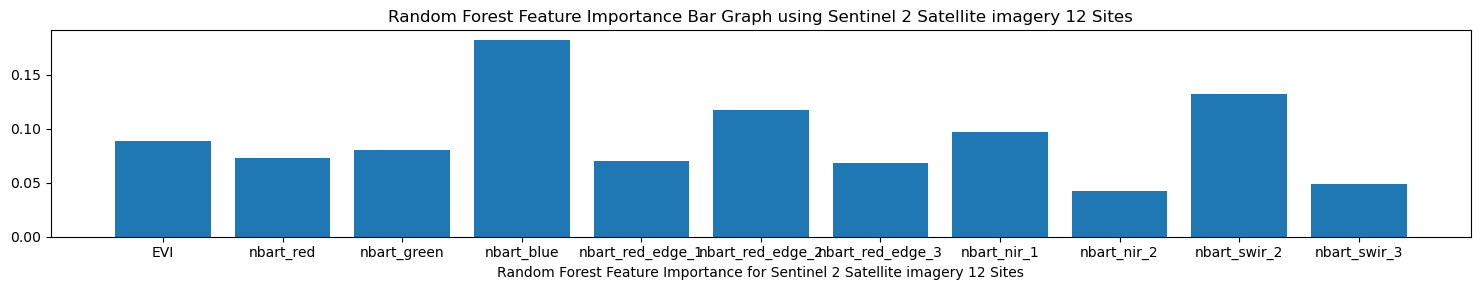

In [147]:
# Train the model

# X_train = all_df_pred
# y_train = resp_df

rf.fit(X_train, y_train)


fig, ax = plt.subplots(figsize=(15, 3))
X_Variables = X_train.columns
plt.bar(X_Variables, rf.feature_importances_, orientation = 'vertical')
plt.xlabel("Random Forest Feature Importance for Sentinel 2 Satellite imagery 12 Sites")
plt.title('Random Forest Feature Importance Bar Graph using Sentinel 2 Satellite imagery 12 Sites')

plt.tight_layout()

plt.savefig('Random Forest Feature Importance Bar Graph showing which Spectral Bands and Vegetation Indices played a role in coming to a Prediction.png')

In [148]:
slope, intercept = np.polyfit(predictions1, y_train, 1)

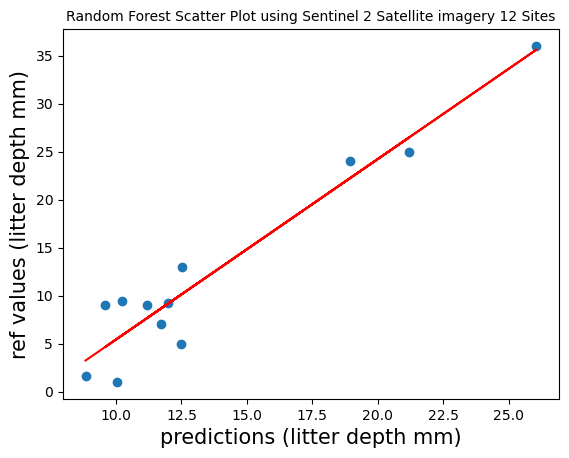

In [149]:
plt.scatter(predictions1,y_train)
plt.xlabel('predictions (litter depth mm)', fontsize=15)
plt.ylabel('ref values (litter depth mm)', fontsize=15)
plt.title('Random Forest Scatter Plot using Sentinel 2 Satellite imagery 12 Sites', fontsize=10)

plt.plot(predictions1, slope * predictions1 + intercept, color='red')

plt.savefig('Random Forest Scatter Plot of Reference Values against Prediction Values Sentinel12')

In [49]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeavePOut, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# Generate a small example dataset
X, y = make_classification(n_samples=12, n_features=5, n_informative=2, n_redundant=2, random_state=42)

# Initialize the classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)

# Initialize LeavePOut with P=2
lpo = LeavePOut(p=2)

# Apply Leave-P-Out cross-validation, where P=2
scores = cross_val_score(rf, X, y, cv=lpo)

# Output the performance
print(f'Leave-Two-Out Cross-Validation Scores: {scores}')
print(f'Mean LTO CV Accuracy: {np.mean(scores)}')

Leave-Two-Out Cross-Validation Scores: [0.5 0.5 0.  0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5 1.  1.  1.  0.5 1.
 1.  0.5 1.  0.  0.5 0.  1.  0.5 1.  1.  0.5 1.  0.5 0.5 0.5 0.  0.5 0.5
 0.5 0.  1.  1.  0.5 1.  1.  0.5 1.  1.  0.5 1.  1.  0.5 1.  0.5 1.  1.
 0.5 1.  0.5 0.5 0.  0.5 1.  1.  1.  0.5 0.5 1. ]
Mean LTO CV Accuracy: 0.6439393939393939


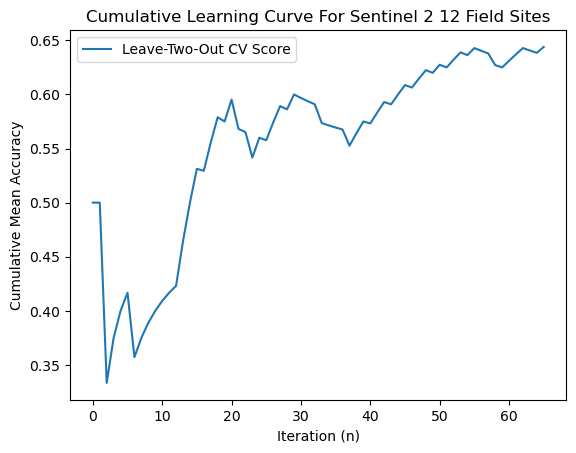

In [53]:
# Generate a small example dataset
X, y = make_classification(n_samples=12, n_features=5, n_informative=2, n_redundant=2, random_state=42)

# Initialize the classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)

# Initialize LeavePOut with P=2
lpo = LeavePOut(p=2)

# Apply Leave-P-Out cross-validation, where P=2
scores = cross_val_score(rf, X, y, cv=lpo)

# Calculate the cumulative mean of the scores up to each point
cumulative_mean_score = np.cumsum(scores) / np.arange(1, len(scores) + 1)

# Plotting the 'learning curve'
plt.plot(cumulative_mean_score, label='Leave-Two-Out CV Score')
plt.xlabel('Iteration (n)')
plt.ylabel('Cumulative Mean Accuracy')
plt.title('Cumulative Learning Curve For Sentinel 2 12 Field Sites')
plt.legend()
plt.show()

In [52]:
cumulative_mean_score

array([0.5       , 0.5       , 0.33333333, 0.375     , 0.4       ,
       0.41666667, 0.35714286, 0.375     , 0.38888889, 0.4       ,
       0.40909091, 0.41666667, 0.42307692, 0.46428571, 0.5       ,
       0.53125   , 0.52941176, 0.55555556, 0.57894737, 0.575     ,
       0.5952381 , 0.56818182, 0.56521739, 0.54166667, 0.56      ,
       0.55769231, 0.57407407, 0.58928571, 0.5862069 , 0.6       ,
       0.59677419, 0.59375   , 0.59090909, 0.57352941, 0.57142857,
       0.56944444, 0.56756757, 0.55263158, 0.56410256, 0.575     ,
       0.57317073, 0.58333333, 0.59302326, 0.59090909, 0.6       ,
       0.60869565, 0.60638298, 0.61458333, 0.62244898, 0.62      ,
       0.62745098, 0.625     , 0.63207547, 0.63888889, 0.63636364,
       0.64285714, 0.64035088, 0.63793103, 0.62711864, 0.625     ,
       0.63114754, 0.63709677, 0.64285714, 0.640625  , 0.63846154,
       0.64393939])

# Auto loop

In [6]:
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import datacube.virtual as virtual
import geopandas as gpd

import sys
sys.path.insert(1, '../Tools/')

from dea_tools.plotting import display_map
from dea_tools.spatial import xr_rasterize, xr_vectorize
from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import display_map, rgb
from odc.io.cgroups import get_cpu_quota
import subprocess
from rasterio.mask import raster_geometry_mask
from shapely.geometry import box

In [7]:
""" additions """

from dea_tools.datahandling import load_ard   # added this
from dea_tools.bandindices import calculate_indices # added this

In [8]:
pip install openpyxl # required to open xlsx files

Note: you may need to restart the kernel to use updated packages.


In [9]:
""" load reference data """
ref_df2 = pd.read_excel('Field Survey Data.xlsx',sheet_name='Sheet1')

In [10]:
filtered_df = ref_df2[(ref_df2['Remnant Status'] == 'remnant') & (ref_df2['EDL'] != 'Water')]   # filter the df for an auto loop

In [11]:
filtered_df.head()

,Sequence,Latitude (GDA2020),Longitude (GDA2020),Site name,Date,Time,Collector(s),Remnant Status,Desktop RE,Groundtruthed RE,...,S2 Cover (%),S2 Species,Basal Area,Ground Layer Notes,Dominant Groundcover,Surface Fine Fuels Average (%),Near Surface Fine Fuels Average (%),Litter Depth Average (mm),General Site Notes,Incidental Flora
3,NaN,27.498831,152.814717,56s.4816996958299,44811,0.559028,"Gina Minatel,Katelyn Gibson",remnant,12.12.15b,12.12.15b,...,0.0,NaN,23.0,Dominated by mostly native species with a thic...,"Chrysocephalum apiculatum,Lantana montevidensi...",99,35.0,38.0,"Site located on a slope, open understory with ...",NaN
4,3.0,27.509657,152.797552,56s.479999.6957099,44811,0.438194,"Gina Minatel,Katelyn Gibson",remnant,12.11.3a,12.11.3a,...,0.0,NaN,14.0,Dominated by lantana montevensis with billy go...,NaN,99,34.0,24.0,In a gully / low lying area next to an ephemer...,NaN
5,4.0,27.510465,152.776266,56s.477899.6956999,44811,0.361111,"Gina Minatel,Katelyn Gibson",remnant,12.11.6,12.11.6,...,0.0,NaN,16.0,Dominated by lantana montdevensis forming a ma...,NaN,80.6,63.0,12.4,NaN,NaN
6,5.0,27.526253,152.864255,56s.486599.6955299,44804,0.474306,"Gillian Turner,Jacinta Harrison",remnant,12.11.5,12.11.5,...,0.0,NaN,10.0,NaN,"Aristida sp.,Lomandra multiflora,Themeda triandra",9,86.8,9.0,NaN,"Achyranthes aspera,Cymbopogon refractus,Entola..."
7,6.0,27.527787,152.863334,56s.486499.6955099,44804,0.474306,"Gillian Turner,Jacinta Harrison",remnant,12.11.3,12.11.5,...,0.0,NaN,23.0,NaN,"Entolasia stricta,Lomandra confertifolia,Theme...",8,81.0,13.0,NaN,"Dianella sp.,Hibbertia sp.,Senecio sp."


In [13]:
# List of central latitude and longitude coordinates for the field sites
field_sites = [
    (-27.49415846, 152.7408134),  # Field site 1
    (-27.4996146, 152.7388185),  # Field site 2
    (-27.50965686, 152.7975522),  # Field site 3
    (-27.52625347, 152.864255),  # Field site 4
    (-27.52778734, 152.8633343),  # Field site 5
    (-27.53948472, 153.1528979),  # Field site 6
    (-27.53771376, 153.1447333),  # Field site 7
    (-27.52950791, 153.1448171),  # Field site 8
    (-27.55665257, 152.8541602),  # Field site 9
    (-27.55483345, 152.8511169), # Field site 10
    (-27.55482989, 152.8551187),  # Field site 11
    (-27.57918881, 153.1671666),  # Field site 12
]

# Set the buffer to load around the central coordinates, 50m by 20m.
buffer_lat = 0.00180
buffer_lon = 0.00505

In [15]:
for site_idx, (central_lat, central_lon) in enumerate(field_sites):
    # if site_idx < 2:
        site_name = 'site_'+str(site_idx)
        print(site_name)

        lat_range = (central_lat - buffer_lat/2, central_lat + buffer_lat/2)
        lon_range = (central_lon - buffer_lon/2, central_lon + buffer_lon/2)
        print(lat_range,lon_range)


site_0
(-27.495058460000003, -27.49325846) (152.73828840000002, 152.7433384)
site_1
(-27.500514600000002, -27.4987146) (152.73629350000002, 152.7413435)
site_2
(-27.51055686, -27.50875686) (152.79502720000002, 152.8000772)
site_3
(-27.527153470000002, -27.52535347) (152.86173000000002, 152.86678)
site_4
(-27.52868734, -27.52688734) (152.8608093, 152.86585929999998)
site_5
(-27.540384720000002, -27.53858472) (153.1503729, 153.1554229)
site_6
(-27.53861376, -27.536813759999998) (153.14220830000002, 153.1472583)
site_7
(-27.53040791, -27.528607909999998) (153.14229210000002, 153.1473421)
site_8
(-27.557552570000002, -27.55575257) (152.8516352, 152.8566852)
site_9
(-27.55573345, -27.55393345) (152.8485919, 152.85364189999999)
site_10
(-27.555729890000002, -27.55392989) (152.8525937, 152.85764369999998)
site_11
(-27.580088810000003, -27.57828881) (153.1646416, 153.1696916)


In [16]:
""" extract the min and max lat/lon from the df """
lat_range = (central_lat - buffer_lat/2, central_lat + buffer_lat/2)
lon_range = (central_lon - buffer_lon/2, central_lon + buffer_lon/2)

for row_v in np.arange(0,len(filtered_df),1):
    lat_arr = np.array([pd.to_numeric(filtered_df.iloc[row_v,:]['Transect Starts (GDA2020)'].split(',')[0])*-1, 
                 pd.to_numeric(filtered_df.iloc[row_v,:]['Transect End (GDA2020)'].split(',')[0])*-1])
    lon_arr = np.array([pd.to_numeric(filtered_df.iloc[row_v,:]['Transect Starts (GDA2020)'].split(',')[1]), 
                 pd.to_numeric(filtered_df.iloc[row_v,:]['Transect End (GDA2020)'].split(',')[1])])
    print(lat_arr, lon_arr)
    
    lat_range = (min(lat_arr), max(lat_arr))
    lon_range = (min(lon_arr), max(lon_arr))


[-27.49887998 -27.49887245] [152.81495999 152.8144791 ]
[-27.50978476 -27.50969748] [152.79767487 152.79719607]
[-27.51047936 -27.51044462] [152.77643806 152.77598218]
[-27.52628176 -27.52621802] [152.86431876 152.86396746]
[-27.52783787 -27.52773174] [152.86346636 152.86305448]
[-27.53952213 -27.53939525] [153.15299384 153.15261762]
[-27.53777081 -27.53763844] [153.14489082 153.14459973]
[-27.53590194 -27.53578848] [153.14704489 153.14663413]
[-27.49806358 -27.49804642] [153.11255501 153.11208486]
[-27.54310738 -27.54302924] [153.14409292 153.14356068]
[-27.40506161 -27.40500835] [153.08420052 153.08370076]
[-27.39788958 -27.39787144] [153.08824201 153.08813301]
[-27.39964872 -27.39956891] [153.0892911  153.08879264]
[-27.505724  -27.5052762] [153.12112363 153.12081467]


In [19]:
# Set the data source - s2a corresponds to Sentinel-2A and s2b corresponds to Sentinel -2B
set_product = ("ga_s2am_ard_3", "ga_s2bm_ard_3")

# Set the date range to load data over
time_range = ("2022-09-01", "2022-09-30")

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
set_crs = "epsg:32756"  # 'epsg:3577'

set_resolution = (-10, 10)

In [21]:
dc = datacube.Datacube(app="Sentinel_2_Vegetation_Fuel_Load")

In [22]:
""" Loop for all sites """

""" define our band (data variable) we want to export and compute a mean and SD """
measurement_list = ['EVI','nbart_red', 'nbart_green', 'nbart_blue', 
                     'nbart_red_edge_1', 'nbart_red_edge_2', 'nbart_red_edge_3', 
                     'nbart_nir_1','nbart_nir_2',
                     'nbart_swir_2', 'nbart_swir_3']


all_df = pd.DataFrame()  #  dataframe to add our band means for each site


for row_v in np.arange(0,len(filtered_df),1):
    
    lat_arr = np.array([pd.to_numeric(filtered_df.iloc[row_v,:]['Transect Starts (GDA2020)'].split(',')[0])*-1, 
                 pd.to_numeric(filtered_df.iloc[row_v,:]['Transect End (GDA2020)'].split(',')[0])*-1])
    lon_arr = np.array([pd.to_numeric(filtered_df.iloc[row_v,:]['Transect Starts (GDA2020)'].split(',')[1]), 
                 pd.to_numeric(filtered_df.iloc[row_v,:]['Transect End (GDA2020)'].split(',')[1])])
    #print(lat_arr, lon_arr)
    
    lat_range = (min(lat_arr), max(lat_arr))
    lon_range = (min(lon_arr), max(lon_arr))

    site_name = 'site_'+str(row_v)
    print(site_name)
    print(lat_range,lon_range)

    # Create a reusable query - all bands and variables
    query = {
        'y': lat_range,
        'x': lon_range,
        'time': time_range,
        'resolution': set_resolution,
        'output_crs': set_crs,
        'group_by': 'solar_day'
    } 

    # Load available data
    ds = load_ard(
        dc=dc,
        products=set_product,
        min_gooddata=0.90,
        **query,
    )

    """ add extra indices """
    # Calculate the chosen vegetation proxy index and add it to the loaded data set
    veg_proxy_list = ['EVI','NDVI','NBR'] #'NDVI'#
    for i_var in veg_proxy_list:   # loop over the veg_proxy_list to add the VIs to the ds
        ds = calculate_indices(ds, index=i_var, collection='ga_s2_3')
        # Save the NDVI to the dask cluster
        ds[i_var] = ds[i_var]

    # Compute a single median from all data
    ds_median = ds.median('time')

    # create lists to add our means
    mu_list_ind = []
    sd_list_ind = []

    for i_var in measurement_list:   # add our means to our lists
        mu_list_ind.append(ds_median[i_var].mean(['x', 'y']).item())
        sd_list_ind.append(ds_median[i_var].std(['x', 'y']).item())  

    all_df_ind = pd.DataFrame(index=measurement_list,data=mu_list_ind,columns=[site_name])   # this is a df for a single site
    all_df = pd.concat([all_df,all_df_ind],axis=1)

all_df    

site_0
(-27.498879980158087, -27.4988724493794) (152.814479096721, 152.81495999390657)
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 3 out of 6 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 3 time steps
site_1
(-27.50978475970104, -27.5096974753479) (152.797196070467, 152.79767487331392)
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 3 out of 6 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 3 time steps
site_2
(-27.510479355480992, -27.5104446215379) (152.775982181981, 152.77643806317153)
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 4 out of 6 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 4 time steps
site_3
(-27.526281756838145, -27.5262180212036) (152.86396745968, 152.8643187563903)
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 3 out of 6 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 3 time steps
site_4
(-27.52783787302129, -27.5277317405101) (152.863054480233, 152.86346636482375)
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 2 out of 6 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 2 time steps
site_5
(-27.539522129679927, -27.5393952532692) (153.152617619773, 153.1529938398156)
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fm

,site_0,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,site_11,site_12,site_13
EVI,0.489644,0.362643,0.339126,0.361651,0.424836,0.349596,0.385561,0.425085,0.375638,0.384079,0.355249,0.315018,0.286282,0.351069
nbart_red,384.833344,378.399994,480.700012,503.600006,598.750000,295.533325,343.250000,331.266663,336.500000,283.333344,754.666687,742.000000,781.208313,370.562500
nbart_green,519.500000,468.299988,514.599976,574.500000,679.849976,382.833344,354.937500,393.733337,425.899994,368.250000,750.291687,763.000000,790.333313,404.375000
nbart_blue,352.500000,408.000000,413.299988,514.099976,596.549988,259.466675,272.500000,297.666656,331.799988,268.333344,571.875000,593.500000,640.166687,303.354156
nbart_red_edge_1,924.833313,663.400024,815.299988,730.599976,976.650024,635.233337,643.937500,696.033325,640.000000,610.500000,1153.166626,1107.750000,1078.208374,683.416687
nbart_red_edge_2,2233.000000,1702.599976,1734.900024,1519.199951,2149.699951,1524.166626,1619.562500,1869.866699,1654.699951,1605.666626,1964.125000,1921.500000,1708.791626,1638.708374
nbart_red_edge_3,2644.333252,2028.400024,2060.800049,1978.199951,2406.800049,1816.900024,1987.687500,2187.866699,1994.599976,1948.916626,2353.791748,2291.750000,2000.666626,1988.125000
nbart_nir_1,2759.000000,2149.899902,2183.199951,2022.099976,2586.500000,1940.033325,2229.812500,2412.533447,2116.699951,2164.750000,2561.916748,2362.750000,2154.541748,2134.666748
nbart_nir_2,2939.666748,2313.199951,2326.199951,2261.199951,2689.800049,2069.933350,2290.187500,2477.000000,2272.100098,2224.750000,2696.666748,2573.000000,2280.791748,2260.166748
nbart_swir_2,1651.166626,1198.199951,1585.800049,1101.599976,1495.949951,1102.099976,1189.625000,1228.933350,1187.300049,1044.250000,2354.166748,2050.000000,2184.333252,1294.625000


Run the RF model

In [23]:
""" specify reponse variable """
resp_var = pd.to_numeric(filtered_df["Litter Depth Average (mm)"].values)

""" swap rows and cols in all_df """
all_df_pred = all_df.T

In [24]:
all_df_pred

,EVI,nbart_red,nbart_green,nbart_blue,nbart_red_edge_1,nbart_red_edge_2,nbart_red_edge_3,nbart_nir_1,nbart_nir_2,nbart_swir_2,nbart_swir_3
site_0,0.489644,384.833344,519.500000,352.500000,924.833313,2233.000000,2644.333252,2759.000000,2939.666748,1651.166626,718.333313
site_1,0.362643,378.399994,468.299988,408.000000,663.400024,1702.599976,2028.400024,2149.899902,2313.199951,1198.199951,546.000000
site_2,0.339126,480.700012,514.599976,413.299988,815.299988,1734.900024,2060.800049,2183.199951,2326.199951,1585.800049,832.700012
site_3,0.361651,503.600006,574.500000,514.099976,730.599976,1519.199951,1978.199951,2022.099976,2261.199951,1101.599976,483.799988
site_4,0.424836,598.750000,679.849976,596.549988,976.650024,2149.699951,2406.800049,2586.500000,2689.800049,1495.949951,710.849976
site_5,0.349596,295.533325,382.833344,259.466675,635.233337,1524.166626,1816.900024,1940.033325,2069.933350,1102.099976,519.799988
site_6,0.385561,343.250000,354.937500,272.500000,643.937500,1619.562500,1987.687500,2229.812500,2290.187500,1189.625000,561.937500
site_7,0.425085,331.266663,393.733337,297.666656,696.033325,1869.866699,2187.866699,2412.533447,2477.000000,1228.933350,524.900024
site_8,0.375638,336.500000,425.899994,331.799988,640.000000,1654.699951,1994.599976,2116.699951,2272.100098,1187.300049,596.799988
site_9,0.384079,283.333344,368.250000,268.333344,610.500000,1605.666626,1948.916626,2164.750000,2224.750000,1044.250000,439.583344


In [25]:
all_df_pred.to_csv('All DF Pred.csv')

In [26]:
resp_df = pd.DataFrame(index=all_df_pred.index, data = resp_var, columns=['resp'])

In [27]:
resp_df = resp_df.drop(resp_df.tail(1).index)

In [28]:
resp_df

,resp
site_0,38.0
site_1,24.0
site_2,12.4
site_3,9.0
site_4,13.0
site_5,9.2
site_6,9.0
site_7,52.5
site_8,13.0
site_9,40.0


In [29]:
len(all_df_pred), len(resp_df)

(14, 13)

In [30]:
y_train = resp_df

In [32]:
y_train

,resp
site_0,38.0
site_1,24.0
site_2,12.4
site_3,9.0
site_4,13.0
site_5,9.2
site_6,9.0
site_7,52.5
site_8,13.0
site_9,40.0


In [33]:
y_train

,resp
site_0,38.0
site_1,24.0
site_2,12.4
site_3,9.0
site_4,13.0
site_5,9.2
site_6,9.0
site_7,52.5
site_8,13.0
site_9,40.0


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regressor
rf = RandomForestRegressor(n_estimators=50)

In [36]:
X_train = all_df_pred.drop(all_df_pred.tail(1).index) # drop last row
y_train = resp_df

rf.fit(X_train, y_train)

# Make prediction
predictions = rf.predict(X_train)

In [37]:
predictions

array([34.508, 19.724, 13.204, 10.272, 23.744, 16.392, 15.4  , 42.596,
       16.02 , 28.55 ,  2.948,  1.66 ,  2.104])

In [38]:
len(predictions)

13

In [39]:
len(resp_df)

13

In [40]:
resp_df

,resp
site_0,38.0
site_1,24.0
site_2,12.4
site_3,9.0
site_4,13.0
site_5,9.2
site_6,9.0
site_7,52.5
site_8,13.0
site_9,40.0


In [41]:
resp_df

,resp
site_0,38.0
site_1,24.0
site_2,12.4
site_3,9.0
site_4,13.0
site_5,9.2
site_6,9.0
site_7,52.5
site_8,13.0
site_9,40.0


In [42]:
len(predictions)

13

In [43]:
len(resp_df)

13

In [45]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [46]:
""" evaluate model """

# Mean absolute error (MAE)
mae = mean_absolute_error(y_train.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_train.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_train.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 4.96
Mean Squared Error: 37.77
R-squared scores: 0.85


In [ ]:
# Train the model

# X_train = all_df_pred
# y_train = resp_df

rf.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(20, 3))
plt.xticks(rotation=0)  # Rotate the x-axis labels by 90 degrees
X_Variables = X_train.columns
plt.bar(X_Variables, rf.feature_importances_, orientation = 'vertical')
plt.xlabel("Random Forest Feature Importance for Sentinel 2", fontsize=15)

plt.title('Random Forest Feature Importance Bar Graph using Sentinel 2 imagery')
plt.savefig('Random Forest Feature Importance Bar Graph using Sentinel 2 imagery_14_Sites.png')


In [ ]:
plt.scatter(X_train.EVI,y_train)
plt.xlabel('evi')
plt.ylabel('ref values')


In [ ]:
slope, intercept = np.polyfit(predictions, y_train, 1)

In [ ]:
plt.scatter(predictions,y_train)
plt.xlabel('predictions (litter depth mm)', fontsize=15)
plt.ylabel('ref values (litter depth mm)', fontsize=15)
plt.plot(predictions, slope * predictions + intercept, color='red')
plt.title('Random Forest Scatter Plot Using Sentinel 2 for the alternative sites')
plt.savefig('Random Forest Scatter Plot of Reference Values against Prediction Values Sentinel14.png')

In [47]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeavePOut, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# Generate a small example dataset
X, y = make_classification(n_samples=14, n_features=5, n_informative=2, n_redundant=2, random_state=42)

# Initialize the classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)

# Initialize LeavePOut with P=2
lpo = LeavePOut(p=2)

# Apply Leave-P-Out cross-validation, where P=2
scores = cross_val_score(rf, X, y, cv=lpo)

# Output the performance
print(f'Leave-Two-Out Cross-Validation Scores: {scores}')
print(f'Mean LTO CV Accuracy: {np.mean(scores)}')

Leave-Two-Out Cross-Validation Scores: [1.  0.5 1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.5 1.
 1.  0.5 0.5 0.5 0.5 0.5 1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.
 1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1. ]
Mean LTO CV Accuracy: 0.8296703296703297


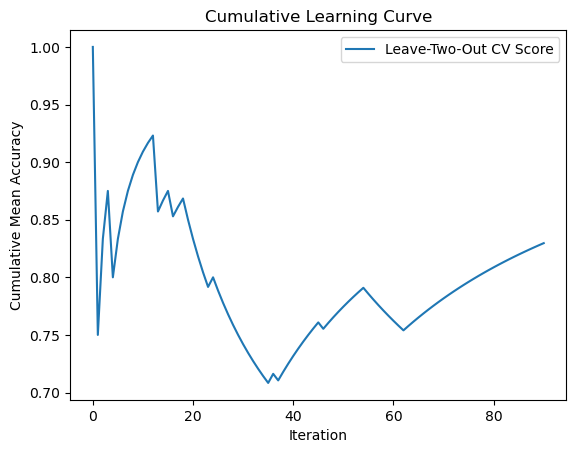

In [48]:
# Generate a small example dataset
X, y = make_classification(n_samples=14, n_features=5, n_informative=2, n_redundant=2, random_state=42)

# Initialize the classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)

# Initialize LeavePOut with P=2
lpo = LeavePOut(p=2)

# Apply Leave-P-Out cross-validation, where P=2
scores = cross_val_score(rf, X, y, cv=lpo)

# Calculate the cumulative mean of the scores up to each point
cumulative_mean_score = np.cumsum(scores) / np.arange(1, len(scores) + 1)

# Plotting the 'learning curve'
plt.plot(cumulative_mean_score, label='Leave-Two-Out CV Score')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Mean Accuracy')
plt.title('Cumulative Learning Curve')
plt.legend()
plt.show()

# END

#### Load Sentinel 2 data into Jupyter environment 

In [ ]:

for site_idx, (central_lat, central_lon) in enumerate(field_sites, start=0):
    # Compute the bounding box for the study areas
    study_area_lat = (central_lat - buffer_lat, central_lat + buffer_lat)
    study_area_lon = (central_lon - buffer_lon, central_lon + buffer_lon)
    #var obj = {};
    ds.append(dc.load(
        product=set_product,
        time=set_time,
        x=study_area_lon,
        y=study_area_lat,       
        output_crs=set_crs,
        resolution=set_resolution,
    ))
    counter = counter + 1

In [ ]:
# Print the number of loaded datasets
print("Loaded datasets:", len(ds))

In [ ]:
print(study_area_lat)
print(study_area_lon)

In [ ]:
# Call the display_map function to visualize the study area
display_map(x=study_area_lon, y=study_area_lat)

In [ ]:
ds

In [ ]:
# View a red, green, blue (true colour) image of the first timestep
rgb(ds[0], bands=["nbart_red", "nbart_green", "nbart_blue"], index=2,)
plt.title('Spectral Reflectance Values over all timesteps')

In [ ]:
# Calculate the components that make up the NDVI calculation
band_diff = ds[0].nbart_nir_1 - ds[0].nbart_red
band_sum = ds[0].nbart_nir_1 + ds[0].nbart_red

# Calculate NDVI and store it as a measurement in the original dataset
ndvi = band_diff / band_sum

In [ ]:
# Set the NDVI time step to view
ndvi_time_step = 0

# This is the simple way to plot
# Note that high values are likely to be vegetation.
plt.figure(figsize=(10, 10))
ndvi.isel(time=ndvi_time_step).plot(cmap="RdYlGn")
plt.title('NDVI for first timestep')
plt.show()

In [ ]:
# Plot all timesteps in the dataset
rgb(ds[0], bands=["nbart_red", "nbart_green", "nbart_blue"], col="time")
plt.title('Spectral Reflectance Values over all timesteps')

In [ ]:
ds[0].mean(['x', 'y']).nbart_red

In [ ]:
ds[0].nbart_green.mean(['x', 'y']).plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values over all timesteps')

In [ ]:
ds[1].mean(['x','y']).nbart_green.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[2].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[3].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[4].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[5].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[6].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[7].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[8].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[9].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[10].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
ds[11].mean(['x','y']).nbart_nir_2.plot.line('b-^', figsize=(11, 4))
plt.title('Spectral Reflectance Values')

In [ ]:
# create new list containing image date and index




In [ ]:
ds[2].mean(['x','y'])

In [ ]:
# Set the time step to view
time_step = 0

# Set the band combination to plot
bands = ["nbart_red", "nbart_green", "nbart_blue"]

# Generate the image by running the rgb function
rgb(ds, bands=bands, index=time_step, size=10)

# Format the time stamp for use as the plot title
time_string = str(ds.time.isel(time=time_step).values).split('.')[0]  

# Set the title and axis labels
ax = plt.gca()
ax.set_title(f"Timestep {time_string}", fontweight='bold', fontsize=16)
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Display the plot
plt.show()

### Create Bounding Box for ROI

In [ ]:
# Calculate the bounding box for the ROI
roi_min_lon, roi_min_lat, roi_max_lon, roi_max_lat = get_roi_bbox(center_lat, center_lon, buffer_lat, buffer_lon)

print("ROI Bounding Box:")
print(f"Min Longitude: {roi_min_lon}")
print(f"Min Latitude: {roi_min_lat}")
print(f"Max Longitude: {roi_max_lon}")
print(f"Max Latitude: {roi_max_lat}")

In [ ]:
# Set the data source - s2a corresponds to Sentinel-2A and s2b corresponds to Sentinel -2B
    set_product = ("ga_s2am_ard_3", "ga_s2bm_ard_3")

# Set the date range to load data over
    set_time = ("2022-09-01", "2022-09-30")

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
    set_crs = "epsg:7856"
    set_resolution = (-10, 10)
    
    # insert code here to loop over
    ds = dc.load(
        product=set_product,
        x=study_area_lon,
        y=study_area_lat,
        time=set_time,
        output_crs=set_crs,
        resolution=set_resolution,
    )  

### Repeat for other 11 field sites in study area

In [ ]:
# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
    "nbart_red",
    "nbart_blue",
    "nbart_green",
    "nbart_nir_1"
]
